In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Train Data

In [31]:
from data_processing import get_tabular_dataset2

data_train, data_test = get_tabular_dataset2(save=False)

In [32]:
data_train = pd.read_csv("Data/Train/tabular_train.csv")
data_test = pd.read_csv("Data/Test/tabular_test.csv")

In [4]:
data_train["Id_split"] = data_train["Id"].str.split("_")
data_train["number_sta"] = data_train["Id_split"].apply(lambda s: s[0]).astype(int)
data_train["day"] = data_train["Id_split"].apply(lambda s: s[1]).astype(int)

In [33]:
from data_processing import add_nbr_precp

data_train = add_nbr_precp(data_train, K=5)

100%|██████████| 730/730 [00:15<00:00, 47.22it/s]


In [34]:
data_test = add_nbr_precp(data_test, K=5)

100%|██████████| 363/363 [00:07<00:00, 51.04it/s]


In [35]:
data_test["mean_nbr_precip"] = data_test[["precip_cumul"] + [f"nbr{k}_precip" for k in range(1, 5+1)]].mean(axis=1)
data_test["number_sta"] = data_test["Id"].str.split("_").apply(lambda s: s[0]).astype(int)
for d in range(1,8):
    data_test[f"precip_day-{d}"] = data_test.groupby("number_sta")["precip_cumul"].shift(d)
for d in range(2, 8):
    data_test[f"precip_avg{d}d"] = data_test[["precip_cumul"] + [f"precip_day-{k}" for k in range(1, d)]].mean(axis=1)

In [36]:
data_train["mean_nbr_precip"] = data_train[["precip_cumul"] + [f"nbr{k}_precip" for k in range(1, 5+1)]].mean(axis=1)

In [37]:
data_train["number_sta"] = data_train["Id"].str.split("_").apply(lambda s: s[0]).astype(int)
for d in range(1,8):
    data_train[f"precip_day-{d}"] = data_train.groupby("number_sta")["precip_cumul"].shift(d)
data_train

,Id,Ground_truth,baseline_obs,baseline_pred,month,lat,lon,height_sta,precip_cumul,precip_0,...,nbr5_precip,mean_nbr_precip,number_sta,precip_day-1,precip_day-2,precip_day-3,precip_day-4,precip_day-5,precip_day-6,precip_day-7
0,14066001_0,3.4,0.2,5.545129,1,49.334,-0.431,2.0,0.2,0.0,...,NaN,4.925000,14066001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14126001_0,0.5,0.5,6.791890,1,49.145,0.042,125.0,0.5,0.0,...,1.6,0.980000,14126001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14137001_0,3.4,NaN,6.423514,1,49.180,-0.456,67.0,0.0,0.0,...,0.4,3.180000,14137001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14216001_0,4.0,0.6,8.490187,1,48.928,-0.149,155.0,0.6,0.0,...,1.8,0.933333,14216001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14296001_0,13.3,0.2,26.130000,1,48.795,-1.037,336.0,0.2,0.0,...,NaN,1.533333,14296001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162102,86137003_729,5.0,NaN,6.368405,12,47.035,0.098,96.0,3.4,1.0,...,NaN,5.400000,86137003,1.2,0.0,2.4,5.8,0.0,0.0,0.4
162103,86165005_729,3.2,NaN,2.460211,12,46.412,0.841,153.0,5.6,1.2,...,5.6,5.866667,86165005,1.2,1.6,5.0,4.8,0.0,0.0,0.6
162104,86272002_729,1.8,NaN,3.793858,12,46.839,0.457,120.0,5.6,1.2,...,NaN,5.600000,86272002,1.6,0.2,1.2,5.0,0.0,0.0,0.0
162105,91200002_729,1.6,NaN,4.961200,12,48.526,1.993,116.0,5.6,0.4,...,20.6,9.680000,91200002,7.3,0.0,1.2,0.4,0.2,0.0,3.4


In [38]:
for d in range(2, 8):
    data_train[f"precip_avg{d}d"] = data_train[["precip_cumul"] + [f"precip_day-{k}" for k in range(1, d)]].mean(axis=1)

In [39]:
from sklearn.model_selection import train_test_split

X = data_train.drop(columns=["Id","Ground_truth"])
y = np.log(1 + data_train["Ground_truth"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

# Model training

In [61]:
def MAPE(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true.get_label() - y_pred) / (y_true.get_label()+1)))

In [72]:
def mape_grad(y_pred, y_true):
    '''
    Calculate the gradient and hessian of mean absolute percentage loss 
    from predicted and true values 
    '''
    n_samples = y_pred.shape[0]
    G = 100 / (n_samples * y_true)
    gradient = np.where(y_pred < y_true, G, -G)
    hessian = np.ones_like(y_pred)
    return gradient, hessian

In [83]:
from xgboost import XGBRegressor

xgb_gpu = XGBRegressor(
    objective = mape_grad,
    tree_method = 'gpu_hist', 
    n_estimators = 1000,
    max_depth = 5,
    learning_rate = .5,
    # colsample_bytree = 0.9,
    gpu_id = 0,
    verbosity=1
)

In [84]:
xgb_gpu.fit(X_train, y_train,
            # eval_metric = "mape", 
            eval_set=[(X_train, y_train), (X_test, y_test)], 
            early_stopping_rounds=10)

[0]	validation_0-rmse:0.83988	validation_1-rmse:0.84178
[1]	validation_0-rmse:0.83946	validation_1-rmse:0.84137
[2]	validation_0-rmse:0.83905	validation_1-rmse:0.84095
[3]	validation_0-rmse:0.83864	validation_1-rmse:0.84054
[4]	validation_0-rmse:0.83822	validation_1-rmse:0.84013
[5]	validation_0-rmse:0.83781	validation_1-rmse:0.83972
[6]	validation_0-rmse:0.83740	validation_1-rmse:0.83930
[7]	validation_0-rmse:0.83699	validation_1-rmse:0.83889
[8]	validation_0-rmse:0.83657	validation_1-rmse:0.83848
[9]	validation_0-rmse:0.83616	validation_1-rmse:0.83807
[10]	validation_0-rmse:0.83575	validation_1-rmse:0.83766
[11]	validation_0-rmse:0.83534	validation_1-rmse:0.83725
[12]	validation_0-rmse:0.83493	validation_1-rmse:0.83684
[13]	validation_0-rmse:0.83452	validation_1-rmse:0.83643
[14]	validation_0-rmse:0.83411	validation_1-rmse:0.83602
[15]	validation_0-rmse:0.83370	validation_1-rmse:0.83561
[16]	validation_0-rmse:0.83329	validation_1-rmse:0.83520
[17]	validation_0-rmse:0.83288	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1,
             objective=<function mape_grad at 0x000002A2198A8280>,
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
             validate_parameters=1, verbosity=1)

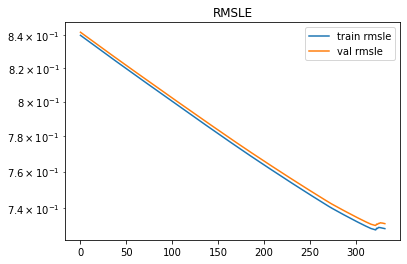

In [85]:
evals_result = xgb_gpu.evals_result()

# plt.plot(evals_result['validation_0']['rmsle'], label='test rmsle')
plt.semilogy(evals_result['validation_0']['rmse'], label='train rmsle')
plt.semilogy(evals_result['validation_1']['rmse'], label='val rmsle')
plt.title('RMSLE')
plt.legend()
plt.show()

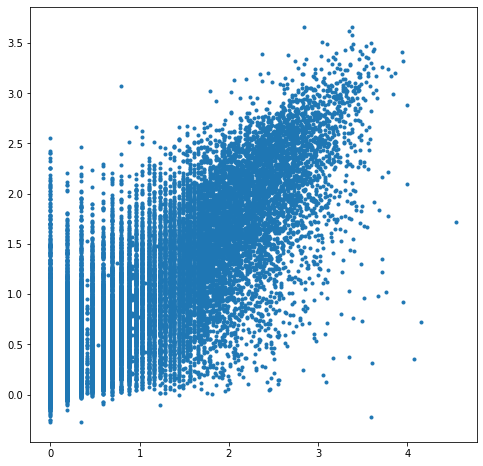

28.125585859432405


In [26]:
y_pred = xgb_gpu.predict(X_test)

plt.figure(figsize=(8,8))
# plt.plot((0,50), (0,50), "k")
plt.plot(y_test, y_pred, ".")
# plt.loglog(y_test+1, y_pred+1, ".")
plt.show()

# print(MAPE(y_test, y_pred)) # previous best: 27.9057
print(MAPE(np.exp(y_test)-1, np.exp(y_pred)-1)) # previous best: 27.9057

In [28]:
from xgboost import XGBRegressor

xgb_gpu = XGBRegressor(
    objective = mape_grad,
    eva_metric = "rmse",
    tree_method = 'gpu_hist', 
    n_estimators = 1000,
    max_depth = 5,
    # max_bin = 512,
    learning_rate = 0.1,
    # colsample_bytree = 0.9,
    gpu_id = 0,
    verbosity=1
)

In [90]:
xgb_gpu.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100)

[0]	validation_0-rmse:0.78095
[1]	validation_0-rmse:0.73207
[2]	validation_0-rmse:0.68951
[3]	validation_0-rmse:0.65294
[4]	validation_0-rmse:0.62156
[5]	validation_0-rmse:0.59464
[6]	validation_0-rmse:0.57188
[7]	validation_0-rmse:0.55240
[8]	validation_0-rmse:0.53597
[9]	validation_0-rmse:0.52237
[10]	validation_0-rmse:0.51085
[11]	validation_0-rmse:0.50082
[12]	validation_0-rmse:0.49265
[13]	validation_0-rmse:0.48551
[14]	validation_0-rmse:0.47938
[15]	validation_0-rmse:0.47439
[16]	validation_0-rmse:0.47018
[17]	validation_0-rmse:0.46628
[18]	validation_0-rmse:0.46313
[19]	validation_0-rmse:0.46028
[20]	validation_0-rmse:0.45797
[21]	validation_0-rmse:0.45563
[22]	validation_0-rmse:0.45392
[23]	validation_0-rmse:0.45228
[24]	validation_0-rmse:0.45089
[25]	validation_0-rmse:0.44949
[26]	validation_0-rmse:0.44846
[27]	validation_0-rmse:0.44754
[28]	validation_0-rmse:0.44661
[29]	validation_0-rmse:0.44582
[30]	validation_0-rmse:0.44514
[31]	validation_0-rmse:0.44442
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=3000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=1)

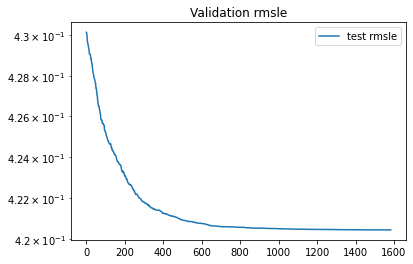

In [91]:
evals_result = xgb_gpu.evals_result()

# plt.plot(evals_result['validation_0']['rmsle'], label='test rmsle')
plt.semilogy(evals_result['validation_0']['rmse'][100:], label='test rmsle')
plt.title('Validation rmsle')
plt.legend()
plt.show()

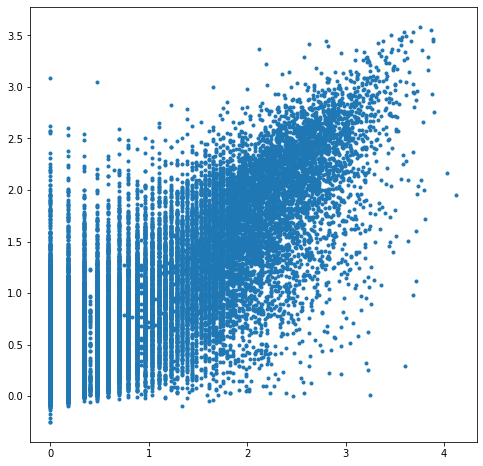

28.81351091945677


In [92]:
y_pred = xgb_gpu.predict(X_test)

plt.figure(figsize=(8,8))
# plt.plot((0,50), (0,50), "k")
plt.plot(y_test, y_pred, ".")
# plt.loglog(y_test+1, y_pred+1, ".")
plt.show()

# print(MAPE(y_test, y_pred)) # previous best: 27.9057
print(MAPE(np.exp(y_test)-1, np.exp(y_pred)-1)) # previous best: 27.9057

# Bayesian Optimization

In [5]:
from sklearn.model_selection import train_test_split

X = data_train.drop(columns=["Id","Ground_truth", "number_sta", "baseline_obs"])
y = np.log(1 + data_train["Ground_truth"])
X_cv, X_val, y_cv, y_val = train_test_split(X, y, test_size=.2)

KeyError: "['number_sta'] not found in axis"

In [28]:
X_station = pd.read_csv("Data\Train\X_station_train.csv")

In [33]:
missing.index

Index(['dd', 'ff', 'td', 'hu', 'precip', 't'], dtype='object')

In [43]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

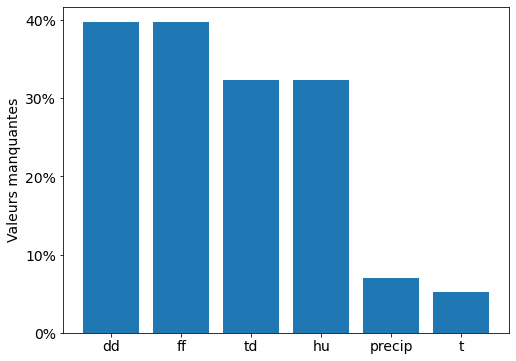

In [46]:
plt.figure(figsize=(8,6))
missing = (X_station.isna().sum() / len(X_station)).sort_values(ascending=False)[:6]
plt.bar(np.arange(6), missing)
plt.xticks(np.arange(6), missing.index)
plt.yticks(np.arange(0, 0.5, 0.1), [f"{p}%" for p in np.arange(0, 50, 10)])
plt.ylabel("Valeurs manquantes")
plt.savefig("plots/valeurs_manquantes.png", dpi=300)

In [177]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import CheckpointSaver
from xgboost import XGBRegressor

def MAPE(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / (y_true+1)))

def mape_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return 100 - MAPE(np.exp(y) - 1, np.exp(y_pred) - 1)

parameter_space = dict(
    n_estimators = Integer(200, 1500, prior="uniform"),
    max_depth = Integer(3, 10, prior="uniform"),
    learning_rate = Real(0.01, 0.3, prior="uniform"),
    gamma = Real(1e-6, 1e+1, prior="log-uniform"),
    min_child_weight = Real(1e-6, 1e+1, prior="log-uniform"),
    max_delta_step = Real(1e-2, 1e+2, prior="log-uniform"),
    colsample_bylevel  = Real(0.2, 1, prior="uniform"),
    colsample_bynode = Real(0.2, 1, prior="uniform")
    # colsample_bytree = Real(0.5, 1, prior="uniform")
    # reg_alpha = Real(1e-6, 1e+1, prior="log-uniform"),
    # reg_lambda = Real(1e-6, 1e+1, prior="log-uniform")
)

xgb_gpu = XGBRegressor(
    objective = "reg:squarederror",
    # eval_metric = "rmse",
    tree_method = 'gpu_hist', 
    gpu_id = 0,
)

xgb_cpu = XGBRegressor(
    objective="reg:squarederror"
)

checkpoint_saver = CheckpointSaver("opt_checkpoints/opt_checkpoint_2.pkl", compress=9)

opt = BayesSearchCV(
    xgb_cpu,
    parameter_space,
    scoring=mape_scorer,
    fit_params=dict(eval_set=[(X_val, y_val)], early_stopping_rounds=10),
    n_iter=10,
    cv=3,
    verbose=5
)

opt.fit(X_cv, y_cv, callback=checkpoint_saver)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bylevel=0.7020994222267751, colsample_bynode=0.6142907855851673, gamma=1.817287815685178e-05, learning_rate=0.018823230438962033, max_delta_step=11.697578326932131, max_depth=6, min_child_weight=0.0027614221821077546, n_estimators=525;, score=68.753 total time=  53.6s
[CV 2/3] END colsample_bylevel=0.7020994222267751, colsample_bynode=0.6142907855851673, gamma=1.817287815685178e-05, learning_rate=0.018823230438962033, max_delta_step=11.697578326932131, max_depth=6, min_child_weight=0.0027614221821077546, n_estimators=525;, score=69.314 total time=  53.4s
[CV 3/3] END colsample_bylevel=0.7020994222267751, colsample_bynode=0.6142907855851673, gamma=1.817287815685178e-05, learning_rate=0.018823230438962033, max_delta_step=11.697578326932131, max_depth=6, min_child_weight=0.0027614221821077546, n_estimators=525;, score=69.011 total time=  55.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/

BayesSearchCV(cv=3,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                             'learning_rate': Real(low=0.01, high=0.3, prior='uniform', transform='normalize'),
                             'max_delta_step': Real(low=0.01, high=100.0, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(lo

In [ ]:
# colsample_bylevel=0.9123335746345143, 
# colsample_bynode=0.7949060658350946, 
# colsample_bytree=1.0, 
# gamma=0.002942423609287807, 
# learning_rate=0.09749077636023099, 
# max_delta_step=0.0970329358188392, 
# max_depth=14, 
# min_child_weight=10.0, 
# n_estimators=2671;, 
# score=71.041 
# total time= 2.9min

# colsample_bylevel=1.0, 
# colsample_bynode=0.5, 
# colsample_bytree=1.0, 
# gamma=0.000392237407822539, 
# learning_rate=0.04640973110054612, 
# max_delta_step=10.0, 
# max_depth=14, 
# min_child_weight=10.0, 
# n_estimators=2107;, 
# score=71.591 
# total time= 5.3min

# colsample_bylevel=0.9361643554194089, colsample_bynode=0.5, colsample_bytree=1.0, gamma=1e-06, learning_rate=0.08677181776615807, max_delta_step=0.08950566759766272, max_depth=14, min_child_weight=10.0, n_estimators=3198;, score=71.512 total time= 7.6min

In [6]:
from skopt import load

res = load("opt_checkpoints/opt_checkpoint_2.pkl")

In [15]:
dir(res)
res.specs

{'args': {'dimensions': [Real(low=0.2, high=1, prior='uniform', transform='normalize'),
   Real(low=0.2, high=1, prior='uniform', transform='normalize'),
   Real(low=1e-06, high=10.0, prior='log-uniform', transform='normalize'),
   Real(low=0.01, high=0.3, prior='uniform', transform='normalize'),
   Real(low=0.01, high=100.0, prior='log-uniform', transform='normalize'),
   Integer(low=3, high=10, prior='uniform', transform='normalize'),
   Real(low=1e-06, high=10.0, prior='log-uniform', transform='normalize'),
   Integer(low=200, high=1500, prior='uniform', transform='normalize')],
  'base_estimator': 'gp',
  'n_random_starts': None,
  'n_initial_points': 10,
  'initial_point_generator': 'random',
  'n_jobs': 1,
  'acq_func': 'gp_hedge',
  'acq_optimizer': 'auto',
  'random_state': RandomState(MT19937) at 0x1F589E7F940,
  'model_queue_size': None,
  'acq_func_kwargs': None,
  'acq_optimizer_kwargs': None},
 'function': 'Optimizer'}

In [12]:
dir(res)
res.x

[0.5023667335183475,
 0.7786569530445597,
 0.29483532003269713,
 0.019200857028411795,
 8.873241615295381,
 10,
 1.7307467212068013,
 1087]

In [179]:
opt.best_score_

71.98786833433823

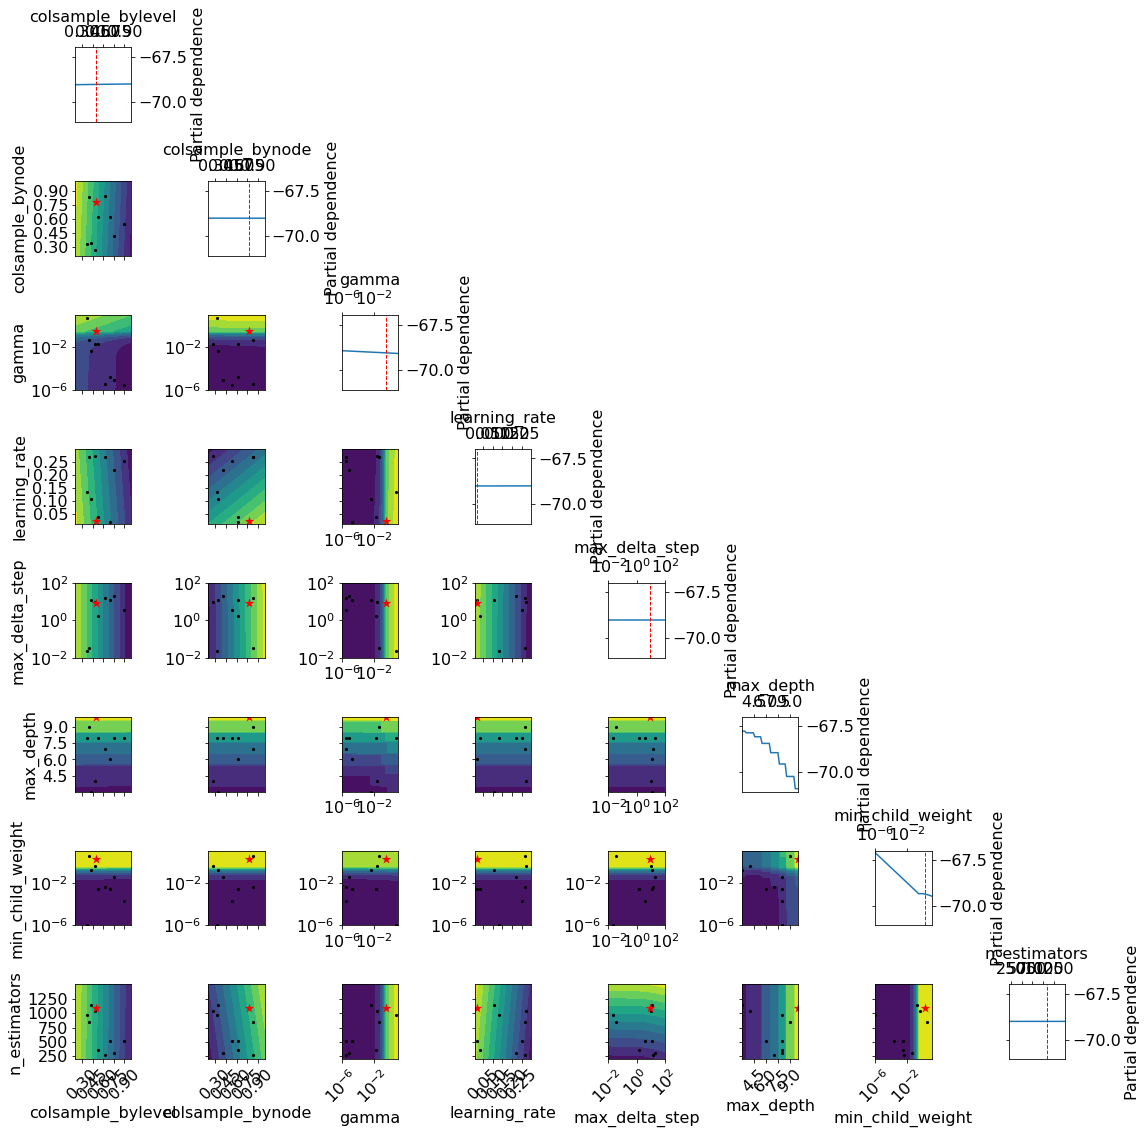

In [11]:
import skopt.plots
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
skopt.plots.plot_objective(
    res,
    # plot_dims=["n_estimators", "max_depth", "learning_rate", "gamma"]
    # bins=10
)
# plt.tight_layout()
plt.tight_layout()
plt.show()
# plt.savefig("plots/bayes_opt.png", dpi=300)

In [48]:
data_train

,Id,Ground_truth,baseline_obs,baseline_pred,lat,lon,height_sta,precip_cumul,precip_0,precip_1,...,dd_20,dd_21,dd_22,dd_23,nbr1_precip,nbr2_precip,nbr3_precip,nbr4_precip,nbr5_precip,mean_nbr_precip
0,14066001_0,3.4,0.2,5.545129,49.334,-0.431,2.0,0.2,0.0,0.0,...,149.0,149.0,150.0,142.0,6.0,0.0,NaN,13.5,NaN,4.925000
1,14126001_0,0.5,0.5,6.791890,49.145,0.042,125.0,0.5,0.0,0.0,...,NaN,NaN,NaN,NaN,0.4,2.0,NaN,0.4,1.6,0.980000
2,14137001_0,3.4,NaN,6.423514,49.180,-0.456,67.0,0.0,0.0,0.0,...,141.0,159.0,151.0,150.0,13.5,NaN,0.0,2.0,0.4,3.180000
3,14216001_0,4.0,0.6,8.490187,48.928,-0.149,155.0,0.6,0.0,0.0,...,155.0,160.0,164.0,170.0,0.2,2.2,0.4,0.4,1.8,0.933333
4,14296001_0,13.3,0.2,26.130000,48.795,-1.037,336.0,0.2,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,4.4,NaN,0.0,NaN,1.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162102,86137003_729,5.0,NaN,6.368405,47.035,0.098,96.0,3.4,1.0,0.8,...,201.0,202.0,199.0,197.0,NaN,6.0,6.0,6.2,NaN,5.400000
162103,86165005_729,3.2,NaN,2.460211,46.412,0.841,153.0,5.6,1.2,0.8,...,224.0,213.0,231.0,221.0,NaN,NaN,6.4,NaN,5.6,5.866667
162104,86272002_729,1.8,NaN,3.793858,46.839,0.457,120.0,5.6,1.2,1.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6,NaN,5.600000
162105,91200002_729,1.6,NaN,4.961200,48.526,1.993,116.0,5.6,0.4,2.2,...,231.0,228.0,230.0,228.0,9.9,8.3,NaN,4.0,20.6,9.680000


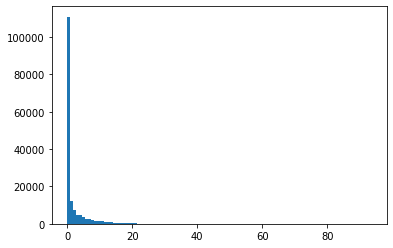

In [19]:
plt.hist(data_train["Ground_truth"], bins=100)
plt.show()

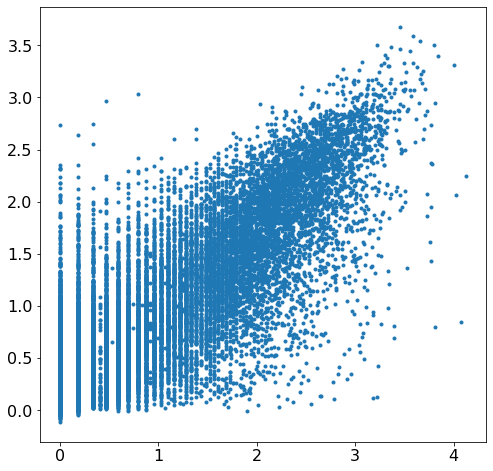

27.245362091107804


In [184]:
y_pred = opt.best_estimator_.predict(X_val)

plt.figure(figsize=(8,8))
# plt.plot((0,50), (0,50), "k")
plt.plot(y_val, y_pred, ".")
# plt.loglog(y_test+1, y_pred+1, ".")
plt.show()

# print(MAPE(y_test, y_pred)) # previous best: 27.9057
print(MAPE(np.exp(y_val)-1, np.exp(y_pred)-1)) # previous best: 27.9057

In [ ]:
["baseline_pred", "lat", ]

In [17]:
opt.best_estimator_.get_booster().get_score(importance_type="gain")

NameError: name 'opt' is not defined

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

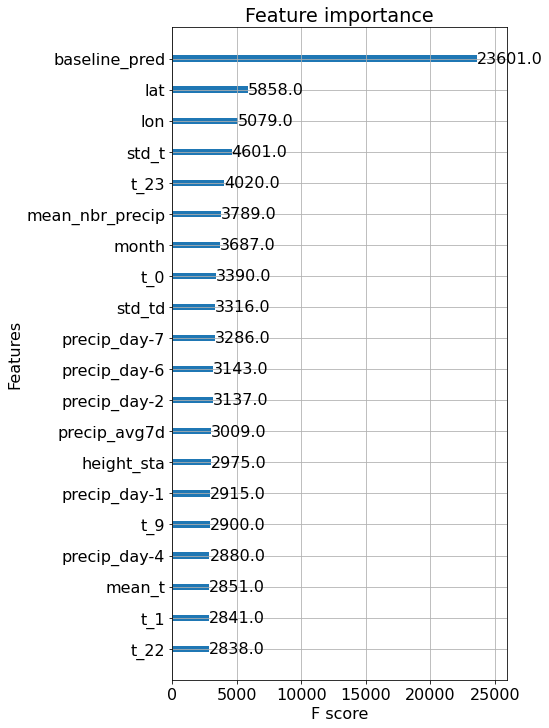

In [185]:
from xgboost import plot_importance

plt.figure(figsize=(6, 12))
plot_importance(opt.best_estimator_, max_num_features=20, ax=plt.gca())


# Final Model

In [13]:
from xgboost import XGBRegressor

final_model = XGBRegressor(
    objective = "reg:squarederror",
    tree_method = 'gpu_hist', 
    n_estimators = 200,
    max_depth = 9,
    learning_rate = 0.1,
    gpu_id = 0,
    verbosity=1
)

# final_model = XGBRegressor(objective = "reg:squarederror", colsample_bylevel=0.5023667335183475, colsample_bynode=0.7786569530445597, gamma=0.29483532003269713, learning_rate=0.019200857028411795, max_delta_step=8.873241615295381, max_depth=10, min_child_weight=1.7307467212068013, n_estimators=1087) #opt.best_estimator_
final_model = XGBRegressor(objective = "reg:squarederror", learning_rate=0.1, max_depth=5, n_estimators=500)

In [14]:
final_model.fit(X_cv, y_cv, eval_set=[(X_cv, y_cv), (X_val, y_val)], early_stopping_rounds=10)
# final_model.fit(X, y, eval_set=[(X, y)], early_stopping_rounds=10)

[0]	validation_0-rmse:0.75987	validation_1-rmse:0.76364
[1]	validation_0-rmse:0.68814	validation_1-rmse:0.69128
[2]	validation_0-rmse:0.62404	validation_1-rmse:0.62649
[3]	validation_0-rmse:0.56666	validation_1-rmse:0.56853
[4]	validation_0-rmse:0.51549	validation_1-rmse:0.51687
[5]	validation_0-rmse:0.46982	validation_1-rmse:0.47075
[6]	validation_0-rmse:0.42929	validation_1-rmse:0.42982
[7]	validation_0-rmse:0.39332	validation_1-rmse:0.39351
[8]	validation_0-rmse:0.36146	validation_1-rmse:0.36137
[9]	validation_0-rmse:0.33340	validation_1-rmse:0.33310
[10]	validation_0-rmse:0.30853	validation_1-rmse:0.30800
[11]	validation_0-rmse:0.28663	validation_1-rmse:0.28619
[12]	validation_0-rmse:0.26760	validation_1-rmse:0.26711
[13]	validation_0-rmse:0.25111	validation_1-rmse:0.25079
[14]	validation_0-rmse:0.23669	validation_1-rmse:0.23653
[15]	validation_0-rmse:0.22408	validation_1-rmse:0.22433
[16]	validation_0-rmse:0.21341	validation_1-rmse:0.21403
[17]	validation_0-rmse:0.20414	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [20]:
plt.plot(dat)

NameError: name 'X' is not defined

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

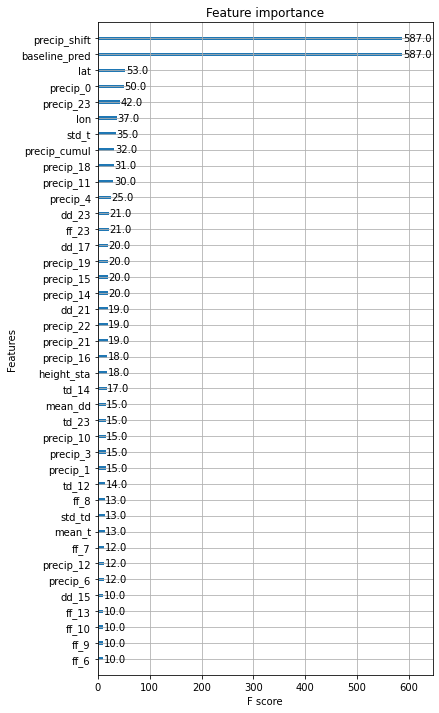

In [15]:
from xgboost import plot_importance

plt.figure(figsize=(6, 12))
plot_importance(final_model, max_num_features=40, ax=plt.gca())
# final_model.get_booster().get_score(importance_type="gain")

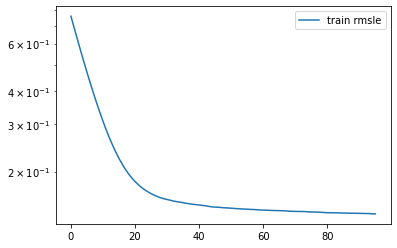

In [17]:
evals_result = final_model.evals_result()

# plt.plot(evals_result['validation_0']['rmsle'], label='test rmsle')
plt.semilogy(evals_result['validation_0']['rmse'], label='train rmsle')
# plt.semilogy(evals_result['validation_1']['rmse'], label='val rmsle')
# plt.title('Validation rmsle')
plt.legend()
plt.show()

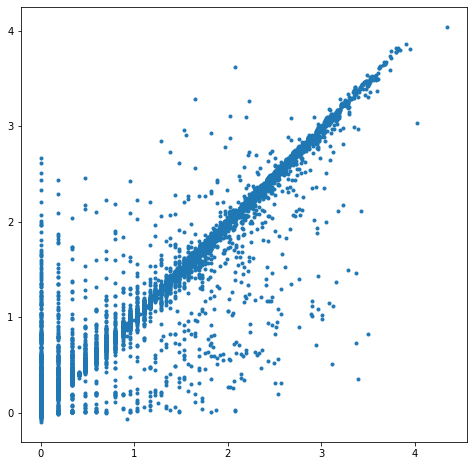

NameError: name 'MAPE' is not defined

In [18]:
y_pred = final_model.predict(X_val)

plt.figure(figsize=(8,8))
# plt.plot((0,50), (0,50), "k")
plt.plot(y_val, y_pred, ".")
# plt.loglog(y+1, y_pred+1, ".")
plt.show()

# print(MAPE(y, y_pred)) # previous best: 28.0478
# print(MAPE(np.exp(y)-1, np.exp(y_pred)-1)) # previous best: 27.9057
print(MAPE(np.exp(y_val)-1, np.exp(y_pred)-1)) # previous best: 27.9057

# Test Data

In [197]:
X_eval = data_test[X.columns]#.drop(columns=["Id", "number_sta", "baseline"])

In [198]:
model_prediction = final_model.predict(X_eval)

In [199]:
submission_df = pd.DataFrame(dict(
    Id = data_test["Id"],
    Prediction = np.exp(model_prediction)
))

In [200]:
submission_df.to_csv("Submissions/submission_5.csv", index=False)